# **Data Cleaning, Trading Strategies and Signals**

### Initial Imports:

In [58]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 300)

from pathlib import Path
import requests

from urllib.request import urlopen
import json
import re  
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import reuters, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LEON\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Additional Installation:

In [2]:
# !pip install yfinance
import yfinance as yf

### Initialization:

In [3]:
# User Inputs for Stock Ticker and Timeframe:
ticker = "TSLA"
start="2019-01-01"
end="2021-1-1"

In [4]:
# EMA & EMA of returns volatility:
short_window = 12
long_window = 26

# Bollinger Band:
bollinger_window = 20

# On Balance Volumn:
OBV_ewm_window = 20

### Download Stock Data from Yahoo Finance and Calculate Returns:

In [5]:
def get_stock_returns (ticker, start, end):
    ''' 
    Taking ticker, start data, end data,
    Download stock data from yahoo finance,
    Return a list of two dataframes:
    1. the original dataframe
    2. a modified dataframe which contains Adj Close, Volume, and calculated daily returns.
    '''
    df_yfinance = yf.download(ticker, start, end)
    df_returns = df_yfinance[["Adj Close", "Volume"]]
    # calculate returns according to the ticker name
    df_returns["Returns"] = df_yfinance[["Adj Close"]].pct_change()
    df_returns.dropna(inplace=True)
    # rename columns according to the ticker name
    df_returns.columns = [(f"{ticker}_"+ column) for column in df_returns.columns]
    return [df_yfinance, df_returns]

In [6]:
# Inspection of download stock data
original_data, returns_df = get_stock_returns(ticker, start, end)

display(original_data.head())
print(" ")
display(original_data.tail())
print(" ")
print("***************** Check Data Quality *****************")
print(original_data.info())
print(" ")
print(original_data.index)
print(" ")
print("***************** Check Returns Data *****************")
display(returns_df.head())
print(returns_df.shape)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,67.557999,67.842003,65.052002,66.559998,66.559998,31511500
2019-01-02,61.220001,63.026001,59.759998,62.023998,62.023998,58293000
2019-01-03,61.400002,61.880001,59.476002,60.071999,60.071999,34826000
2019-01-04,61.200001,63.599998,60.546001,63.537998,63.537998,36970500
2019-01-07,64.344002,67.348000,63.549999,66.991997,66.991997,37756000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600
2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800
2020-12-30,672.000000,696.599976,668.359985,694.780029,694.780029,42846000


 
***************** Check Data Quality *****************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2018-12-31 to 2020-12-30
Data columns (total 6 columns):
Open         505 non-null float64
High         505 non-null float64
Low          505 non-null float64
Close        505 non-null float64
Adj Close    505 non-null float64
Volume       505 non-null int64
dtypes: float64(5), int64(1)
memory usage: 27.6 KB
None
 
DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None)
 
***************** Check Returns Data *****************


,TSLA_Adj Close,TSLA_Volume,TSLA_Returns
Date,,,
2019-01-02,62.023998,58293000,-0.068149
2019-01-03,60.071999,34826000,-0.031472
2019-01-04,63.537998,36970500,0.057697
2019-01-07,66.991997,37756000,0.054361
2019-01-08,67.070000,35042500,0.001164


(504, 3)


### **Trading Signals:**

#### 1. Exponential Moving Average (EMA) Crossover Strategy:
When the short period EMA cuts above the longer period EMA, it is a bullish signal.
<br>When the short period EMA cuts below the longer period EMA, it is a bearish signal. 

Commonly used periods are 12 and 26 periods. (*set as default in this notebook*)

Although, it indicates present trend of the stock, there are many limitations such as:
<br>a. It has the lagging indicator as it relies on some past price movements. 
<br>b. It is more vulnerable to false signals and getting whipsawed back and forth

https://www.warriortrading.com/exponential-moving-average/<br>
https://www.perfecttrendsystem.com/blog_mt4/en/ema-12-ema-26-trading-strategy

In [207]:
def ema(short_window=12, long_window=26):
    df_ema = pd.DataFrame()
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df_ema['fast_close'] = original_data["Adj Close"].ewm(halflife=short_window).mean()
    df_ema['slow_close'] = original_data["Adj Close"].ewm(halflife=long_window).mean()
    # Construct a crossover trading signal
    df_ema['ema_crossover_long'] = np.where(df_ema['fast_close'] > df_ema['slow_close'], 1.0, 0.0)
    df_ema['ema_crossover_short'] = np.where(df_ema['fast_close'] < df_ema['slow_close'], -1.0, 0.0)
    df_ema['ema_crossover_signal'] = df_ema['ema_crossover_long'] + df_ema['ema_crossover_short']
    
    return df_ema

In [208]:
ema().head()

,fast_close,slow_close,ema_crossover_long,ema_crossover_short,ema_crossover_signal
Date,,,,,
2018-12-31,66.559998,66.559998,0.0,0.0,0.0
2019-01-02,64.226514,64.261768,0.0,-1.0,-1.0
2019-01-03,62.760959,62.827785,0.0,-1.0,-1.0
2019-01-04,62.972360,63.012500,0.0,-1.0,-1.0
2019-01-07,63.871734,63.851391,1.0,0.0,1.0


#### 2. EMA of Daily Return Volatility
The upper band shows a level that is statistically high or expensive
<br>The lower band shows a level that is statistically low or cheap
<br>The Bollinger band width correlates to the volatility of the market

Therefore:
<br>In a more volatile market, Bollinger bands widen
<br>In a less volatile market, the bands narrow

When a short-window (fast) EMA of daily return volatility is greater than a long-window (slow) EMA of daily return volatility, <br> the crossover suggests that a short
opportunity exists where daily return volatility is expected to rise.<br>
This is because during times of rising price volatility, <br> there often exists a negative price bias (selling), and vice versa for when daily return volatility is expected to fall (buying).

As suggusted, 20-day Bollinger band calculation period is a good starting point
<br>https://admiralmarkets.com/education/articles/forex-strategy/three-bollinger-bands-strategies-that-you-need-to-know

In [9]:
def volatility(short_window=12, long_window=26):
    df_vol = pd.DataFrame()
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df_vol['fast_vol'] = original_data["Adj Close"].ewm(halflife=short_window).std()
    df_vol['slow_vol'] = original_data["Adj Close"].ewm(halflife=long_window).std()
    # Construct a crossover trading signal (the bigger the spike, more likely is selling)
    df_vol['vol_trend_long'] = np.where(df_vol['fast_vol'] < df_vol['slow_vol'], 1.0, 0.0)
    df_vol['vol_trend_short'] = np.where(df_vol['fast_vol'] > df_vol['slow_vol'], -1.0, 0.0) 
    df_vol['vol_trend_signal'] = df_vol['vol_trend_long'] + df_vol['vol_trend_short']
    return df_vol

In [10]:
volatility().head()

,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,
2018-12-31,NaN,NaN,0.0,0.0,0.0
2019-01-02,3.207436,3.207436,0.0,0.0,0.0
2019-01-03,3.303499,3.317272,1.0,0.0,1.0
2019-01-04,2.687571,2.714303,1.0,0.0,1.0
2019-01-07,2.961697,2.957320,0.0,-1.0,-1.0


#### 3. Bollinger Bands
When the asset closing price is less than the lower band, is a long opportunity.
<br>When the asset closing price is higher than the upper band, is a short opportunity.
<br>As the signal suggests that the price action will tend to move towards to the mean.

In [11]:
def bb(bollinger_window = 20):
    df_bb = pd.DataFrame()
    # Calculate rolling mean and standard deviation
    df_bb['bollinger_mid_band'] = original_data["Adj Close"].ewm(halflife= bollinger_window).mean()
    df_bb['bollinger_std'] = original_data["Adj Close"].ewm(halflife= bollinger_window).std()

    # Calculate upper and lowers bands of bollinger band (Two Standard Deviations)
    df_bb['bollinger_upper_band']  = df_bb['bollinger_mid_band'] + (df_bb['bollinger_std'] * 2)
    df_bb['bollinger_lower_band']  = df_bb['bollinger_mid_band'] - (df_bb['bollinger_std'] * 2)

    # Calculate bollinger band trading signal
    df_bb['bollinger_long'] = np.where(original_data["Adj Close"] < df_bb['bollinger_lower_band'], 1.0, 0.0)
    df_bb['bollinger_short'] = np.where(original_data["Adj Close"] > df_bb['bollinger_upper_band'], -1.0, 0.0)
    df_bb['bollinger_signal'] = df_bb['bollinger_long'] + df_bb['bollinger_short'] 
    return df_bb

In [12]:
bb().head()

,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,
2018-12-31,66.559998,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-02,64.252700,3.207436,70.667572,57.837829,0.0,0.0,0.0
2019-01-03,62.810567,3.313780,69.438127,56.183006,0.0,0.0,0.0
2019-01-04,63.001985,2.707409,68.416804,57.587166,0.0,0.0,0.0
2019-01-07,63.856236,2.958316,69.772868,57.939604,0.0,0.0,0.0


#### 4. On Balance Volume
On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator, adding volume on up days and subtracting it on down days.
<br>The idea behind the indicator is that price follows volume, a widely held belief among many technical analysts.
<br>OBV Indicator is a momentum based indicator which measures volume flow to gauge the direction of the trend.

***OBV EMA is used to generating signals:*** 
<br>When OBV cuts above OBV EMA it is a bullish signal.
<br>When OBV cuts below OBV EMA it is a bearish signal.

https://school.stockcharts.com/doku.php?id=technical_indicators:on_balance_volume_obv
<br>https://blog.quantinsti.com/indicators-build-trend-following-strategy/
<br>https://www.daytrading.com/obv

In [205]:
def obv(OBV_ewm_window=20):
    '''
    Using original_data to:
    Part I: Calculating OBV
    Part II: Store the OBA  and OBV EMA into new columns
    Part III: Creating Trading Signals
    Return a dataframe including OBV signals
    '''
    OBV = [0] # initialization with starting OBV = 0
    df_ob = original_data.copy()
    
    # Part I: Calculating OBV:
    # Loop through the data set (close price) from the second row to the end of the data set
    for i in range(1, len(original_data["Adj Close"])):
        if original_data["Adj Close"][i] > original_data["Adj Close"][i-1]:    
            OBV.append(OBV[-1] + original_data["Volume"][i])
        elif original_data["Adj Close"][i] < original_data["Adj Close"][i-1]:
            OBV.append(OBV[-1] - original_data["Volume"][i])
        else:    
            OBV.append(OBV[-1])
    
    # Part II: Store the OBA  and OBV EMA into new columns:
    df_ob['OBV'] = OBV
    df_ob['OBV_EMA'] = df_ob['OBV'].ewm(halflife=OBV_ewm_window).mean()
    
    # Part III: Creating Trading Signals:
    df_ob['obv_crossover_long'] = np.where(df_ob['OBV'] > df_ob['OBV_EMA'], 1.0, 0.0)
    df_ob['obv_crossover_short'] = np.where(df_ob['OBV'] < df_ob['OBV_EMA'], -1.0, 0.0)
    df_ob['obv_crossover_signal'] = df_ob['obv_crossover_long'] + df_ob['obv_crossover_short']
    
    return df_ob

In [206]:
obv().head()

,Open,High,Low,Close,Adj Close,Volume,OBV,OBV_EMA,obv_crossover_long,obv_crossover_short,obv_crossover_signal
Date,,,,,,,,,,,
2018-12-31,67.557999,67.842003,65.052002,66.559998,66.559998,31511500,0,0.000000e+00,0.0,0.0,0.0
2019-01-02,61.220001,63.026001,59.759998,62.023998,62.023998,58293000,-58293000,-2.965152e+07,0.0,-1.0,-1.0
2019-01-03,61.400002,61.880001,59.476002,60.071999,60.071999,34826000,-93119000,-5.154464e+07,0.0,-1.0,-1.0
2019-01-04,61.200001,63.599998,60.546001,63.537998,63.537998,36970500,-56148500,-5.275611e+07,0.0,-1.0,-1.0
2019-01-07,64.344002,67.348000,63.549999,66.991997,66.991997,37756000,-18392500,-4.539895e+07,1.0,0.0,1.0


#### 5. Scoring Sentiment Using VADER
Following the recommendations from [this research paper](https://scholar.smu.edu/cgi/viewcontent.cgi?article=1051&context=datasciencereview), we will define a threshold of `0.1` to label a review as positive, if the `compound` score is greater than or equal to `0.1`, the news will be positive; if the `compound` score is below `-0.1`, the news will be negative.
<br> a. positive sentiment gives a buy signal
<br> b. negative sentiment gives a sell signal
<br> c. otherwise hold the position

In [54]:
def news():
    """
    this func calls API to Retrieve Data from https://financialmodelingprep.com/
    group articles by date
    return a dataframe according to the requested time frame in a descending order
    the dateframe contains "title" and "text"
    """
    
    url = (f"https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&limit=100000&apikey=e8ac3c3d2405f465935cd797c342b129")
    original_news_df = pd.DataFrame(json.loads(urlopen(url).read().decode("utf-8")))
    # Drop Columns, Only Keep Text and Title
    news_df = original_news_df[["publishedDate", "title", "text"]] 
    # Keep Date Format (remove time i.e 00:00:00)
    news_df['publishedDate'] = pd.to_datetime(news_df['publishedDate']).dt.date
    # Rename and Display in Descending Order
    news_df = news_df.sort_values(by=['publishedDate'], ascending=False)
    news_df = news_df.rename(columns={"publishedDate": "date"})
    # Grouping Articles by Same Date, and Set Date as the Index
    news_df = news_df.groupby(['date'],as_index=True).agg(lambda x : x.sum() if x.dtype=='int64' else ' '.join(x))
    # Trim time interval to the requested time frame
    news_df = news_df.reindex(pd.date_range(start, end)).dropna()
    
    return news_df

In [103]:
news_df=news()
news_df.head()

,title,text
2019-01-01,"Tesla misses Wall Street estimates with 90,700 vehicle deliveries","CNBC's Phil LeBeau reports on Tesla's deliveries for the fourth quarter, which missed forecasts and sent shares lower."
2019-01-03,"Tesla stock drops over missed delivery estimates, price cuts","“Bulls & Bears” panel discusses how Tesla shares dropped after missing delivery estimates and cutting the prices on all of its models by $2,000."
2019-01-06,Cramer: New Tesla factory in Shanghai will work out,"CNBC's Jim Cramer discusses his take on the latest Tesla news: The electric automaker is preparing to open its first non-U.S. factory in Shanghai, China."
2019-01-17,Tesla to cut full time workforce by roughly 7% - WSJ,"The Wall Street Journal is reporting that Tesla is cutting their workforce, hoping to be able to lower the price of the model 3 sedan."
2019-01-18,Behind Elon Musk's Hiring and Firing Spree,"Elon Musk is cutting Tesla Inc.'s workforce by 7 percent -- or more than 3,000 jobs -- warning that the “road ahead is very difficult” in making electric cars more affordable for the mass market. Bloomberg Businessweek's Max Chafkin has more on ""Bloomberg Technology."""


In [151]:
def clean_text(article):
    '''
    this func takes in article, 
    then tokenize the article to individual word,
    then clean it by removing characters that are not letters the including punctuation from text,
    and covert each word to lower case & remove the stop words,
    return a cleaned and list of tokenized words
    '''
    lemmatizer = WordNetLemmatizer()
    # Remove characters that are not letters the including punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    # Create a list of stopwords
    sw = set(stopwords.words('english')) 
    sw_addons = {'including', 'today', 'announced', 'week', 'basically', 'also','ha','wsj','tesla', 'cnbcs'}
    # Covert to lower case & Remove the stop words & then join each word together
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw.union(sw_addons)])
    return output

In [163]:
def content(news_df):
    '''
    this func takes in a dataframe which have "title" and "text" columns,
    then apply clean_text() func to clean each columns,
    then join the cleaned 'tokenized_title' and 'tokenized_text' to a signle 'content' column,
    return a dataframew which only has datetime index and 'content' column
    '''
    # Create a new tokens column for cleaned title and text
    news_df["tokenized_title"]=  news_df["title"].apply(clean_text)  
    news_df["tokenized_text"]=  news_df["text"].apply(clean_text)
    # Join "tokenized_title" and "tokenized_text" columns to a signle column called "content"
    news_df["content"] = news_df["tokenized_title"] +" "+ news_df["tokenized_text"]
    # Creat a new dataframe for "content" only
    content_df=news_df[["content"]]
    return content_df

In [164]:
content(news_df).head()

,content
2019-01-01,miss wall street estimate vehicle delivery phil lebeau report teslas delivery fourth quarter missed forecast sent share lower
2019-01-03,stock drop missed delivery estimate price cut bulls bears panel discus share dropped missing delivery estimate cutting price model
2019-01-06,cramer new factory shanghai work jim cramer discus take latest news electric automaker preparing open first nonus factory shanghai china
2019-01-17,cut full time workforce roughly wall street journal reporting cutting workforce hoping able lower price model sedan
2019-01-18,behind elon musks hiring firing spree elon musk cutting incs workforce percent job warning road ahead difficult making electric car affordable mass market bloomberg businessweeks max chafkin bloomberg technology


In [201]:
def get_sentiment(df):
    '''
    this func takes in a dataframe,
    then it calculates the sentiment scores: compound, positive, negative, neutral,
    then calculate sentiment signals (x>0.1 positive, x<0.1 negative, else 0)
    return a new dataframe contains the sentiment scores and signals
    '''
    # initialization:
    compound = []
    pos = []
    neu = []
    neg = []
    analyzer = SentimentIntensityAnalyzer()
    # calculate sentiment scores:
    for i in range(0, len(df["content"])):
        sentiment = analyzer.polarity_scores(df["content"][i])
        compound.append(sentiment['compound'])
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
    # create a dataframe to hold sentiment scores
    senti_df = df.copy().drop(columns=['content'])
    senti_df['compound'] = compound
    senti_df['positive'] = pos
    senti_df['neutral'] = neu
    senti_df['negative'] = neg
    # calculate sentiment signals
    senti_df["sentiment_signal"] = [1 if x>0.1 else -1 if x<-0.1 else 0 for x in senti_df['compound']]
    
    return senti_df

In [202]:
get_sentiment(content_df).head()

,compound,positive,neutral,negative,sentiment_signal
2019-01-01,-0.4215,0.099,0.631,0.270,-1
2019-01-03,-0.7096,0.087,0.514,0.399,-1
2019-01-06,0.0000,0.000,1.000,0.000,0
2019-01-17,-0.2500,0.130,0.602,0.269,-1
2019-01-18,-0.7783,0.000,0.740,0.260,-1


### **Concatenate Signals:**

In [312]:
def combine():
    '''
    calling this func will combine all returns and signals dataframes with an outer join,
    then it performs a left join of returns and signals,
    then fillna for sentiment signals to 0 (meaning there was no news sentiment available),
    (this could ensure dropping NaN in sentiment signals will not loss the original returns data),
    return a combined and cleaned dataframe of returns and singals.
    '''
    # Combining All Dataframes with Outer Join
    combined_df = pd.concat([returns_df,ema()[['ema_crossover_signal']],volatility()[['vol_trend_signal']],
                       bb()[['bollinger_signal']],obv()[['obv_crossover_signal']],
                       get_sentiment(content_df)[['sentiment_signal']]],axis="columns",join="outer") 
    # Prepare Left Join to make sure returns data is complete
    left = combined_df[['TSLA_Adj Close','TSLA_Volume','TSLA_Returns']].dropna()
    right = combined_df.drop(columns=['TSLA_Adj Close','TSLA_Volume','TSLA_Returns'])
    left.reset_index(inplace=True)
    right.reset_index(inplace=True)
    # Left join returns with signals
    combined_master_df = pd.merge(left, right, on='index', how='left').fillna(0) #fillna for sentiment signal
    # Set index
    combined_master_df.set_index(combined_master_df['index'], inplace=True)
    combined_master_df.drop(columns=['index'], inplace=True)
    
    return combined_master_df

In [313]:
# Inspection of the Data Quality
combined_master_df=combine()
display(combined_master_df.head())
combined_master_df.info() 

,TSLA_Adj Close,TSLA_Volume,TSLA_Returns,ema_crossover_signal,vol_trend_signal,bollinger_signal,obv_crossover_signal,sentiment_signal
index,,,,,,,,
2019-01-02,62.023998,58293000.0,-0.068149,-1.0,0.0,0.0,-1.0,0.0
2019-01-03,60.071999,34826000.0,-0.031472,-1.0,1.0,0.0,-1.0,-1.0
2019-01-04,63.537998,36970500.0,0.057697,-1.0,1.0,0.0,-1.0,0.0
2019-01-07,66.991997,37756000.0,0.054361,1.0,-1.0,0.0,1.0,0.0
2019-01-08,67.070000,35042500.0,0.001164,1.0,1.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2019-01-02 to 2020-12-30
Data columns (total 8 columns):
TSLA_Adj Close          504 non-null float64
TSLA_Volume             504 non-null float64
TSLA_Returns            504 non-null float64
ema_crossover_signal    504 non-null float64
vol_trend_signal        504 non-null float64
bollinger_signal        504 non-null float64
obv_crossover_signal    504 non-null float64
sentiment_signal        504 non-null float64
dtypes: float64(8)
memory usage: 35.4 KB


### **Checking Correlations between Signals:**
Perfect (high) positive or negative correlation suggests the signals are overlaps, and one of it could be dropped.
<br>Zero or Low Correlated Singals are Preferred.

In [314]:
combined_master_df.corr()

,TSLA_Adj Close,TSLA_Volume,TSLA_Returns,ema_crossover_signal,vol_trend_signal,bollinger_signal,obv_crossover_signal,sentiment_signal
TSLA_Adj Close,1.000000,0.087154,0.090041,0.534229,0.141632,-0.092281,0.533255,0.143979
TSLA_Volume,0.087154,1.000000,0.124147,0.293701,0.038578,-0.236549,0.235382,0.095346
TSLA_Returns,0.090041,0.124147,1.000000,0.108819,0.011348,-0.255105,0.177206,0.175152
ema_crossover_signal,0.534229,0.293701,0.108819,1.000000,-0.007240,-0.126636,0.852002,0.258241
vol_trend_signal,0.141632,0.038578,0.011348,-0.007240,1.000000,0.152381,-0.009026,-0.058755
bollinger_signal,-0.092281,-0.236549,-0.255105,-0.126636,0.152381,1.000000,-0.127447,-0.108639
obv_crossover_signal,0.533255,0.235382,0.177206,0.852002,-0.009026,-0.127447,1.000000,0.235606
sentiment_signal,0.143979,0.095346,0.175152,0.258241,-0.058755,-0.108639,0.235606,1.000000


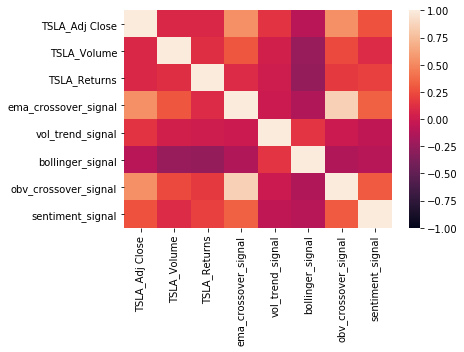

In [315]:
import seaborn as sns
sns.heatmap(combined_df.corr(), vmin = -1, vmax = 1)

***Conclusion:***
<br>Based on the correlation analysis, ema_crossover_signal is highly correlated with obv_crossover_signal (**corr=0.852**).
<br>So, **ema_crossover_signal is dropped.**

In [317]:
# dropping ema_crossover_signal
return_signal_df = combined_master_df.drop(columns=["ema_crossover_signal"])
return_signal_df.head()

,TSLA_Adj Close,TSLA_Volume,TSLA_Returns,vol_trend_signal,bollinger_signal,obv_crossover_signal,sentiment_signal
index,,,,,,,
2019-01-02,62.023998,58293000.0,-0.068149,0.0,0.0,-1.0,0.0
2019-01-03,60.071999,34826000.0,-0.031472,1.0,0.0,-1.0,-1.0
2019-01-04,63.537998,36970500.0,0.057697,1.0,0.0,-1.0,0.0
2019-01-07,66.991997,37756000.0,0.054361,-1.0,0.0,1.0,0.0
2019-01-08,67.070000,35042500.0,0.001164,1.0,0.0,1.0,0.0


In [318]:
# Saved to CSV
return_signal_df.to_csv('Returns and Signals.csv',index_label='Date')